In [57]:
from z3 import *
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
import time
from skimage.morphology import label
from scipy.ndimage import measurements

In [58]:
left = np.array([0,56,0,32,40,15,16,25,0], dtype=int)
right = np.array([0,49,63,0,18,42,63,54,0], dtype=int)
top = np.array([0,35,42,18,18,0,36,63,0], dtype=int)
bottom = np.array([0,40,32,40,10,12,0,56,0], dtype=int)

def sol_print(numbers: np.ndarray, hooks: np.ndarray) -> None:
    _,ax = plt.subplots(1,1,figsize=(8,8))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] = "-"
    ax = sns.heatmap(hooks,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=0.25,annot_kws={"fontsize":12})
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    plt.show()
    
def areas(grid: np.ndarray) -> int:
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))
    return int(np.prod(areas))

In [59]:
def make_hooks(n: int) -> np.ndarray:
    matrix = np.ones((n, n), dtype=int) * (2*n -1)
    matrix[1:,1:] = 0
    return [np.rot90(matrix, i) for i in range(4)]

hook_17, hook_15, hook_13, hook_11, hook_9, hook_7, hook_5, hook_3 = \
    make_hooks(9), make_hooks(8), make_hooks(7), make_hooks(6), make_hooks(5), make_hooks(4), make_hooks(3), make_hooks(2)
    
orthagonal = lambda i, j, N: [(i+di, j+dj) for (di,dj) in [(0,1),(1,0),(0,-1),(-1,0)] if 0<=i+di<N and 0<=j+dj<N]

def hook_constraint(hook_number: int, board: np.ndarray, N: int) -> PbEq:
    hook = dict[int, list]({17: hook_17, 15: hook_15, 13: hook_13, 11: hook_11, 9: hook_9, 7: hook_7, 5: hook_5, 3: hook_3}).get(hook_number)
    shift = N+1 - (hook_number + 1) // 2
    conditions = list[And]()
    for shift_i, shift_j, h in product(range(shift), range(shift), hook):
        conditions.append(And([board[i+shift_i][j+shift_j]==e for (i,j),e in np.ndenumerate(h) if e]))
    return PbEq([(cond, 1) for cond in conditions], 1)

## Total solve time of 204.869 seconds

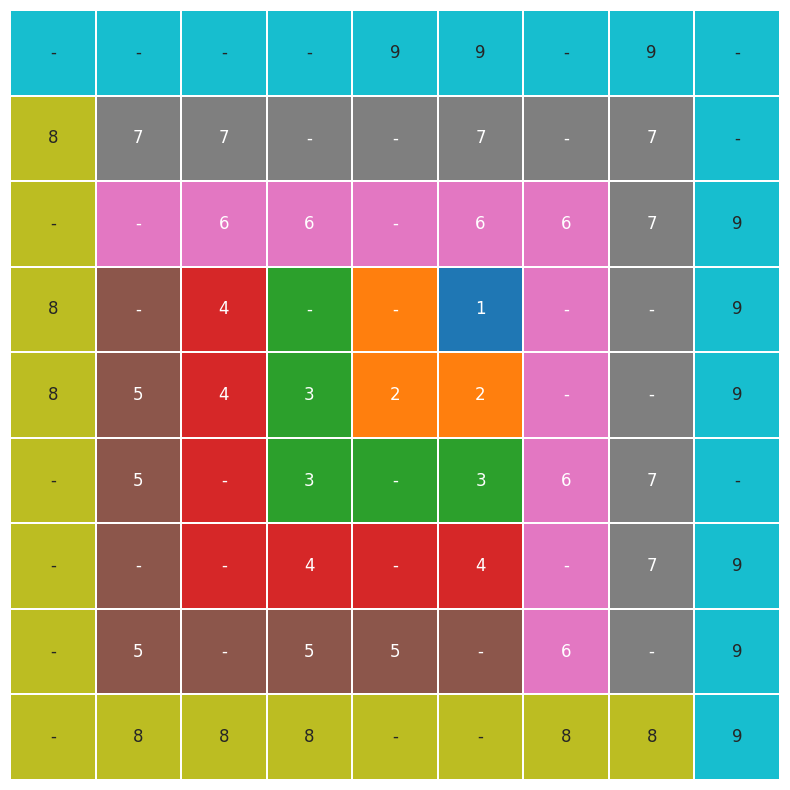

/var/folders/sk/5_qcw5hs4z31pqhw3nxj7wxc0000gn/T/ipykernel_19723/151533244.py:17: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  labels, num = measurements.label(np.logical_not(grid!=0))
/var/folders/sk/5_qcw5hs4z31pqhw3nxj7wxc0000gn/T/ipykernel_19723/151533244.py:18: DeprecationWarning: Please use `sum` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  areas = measurements.sum(np.logical_not(grid>=1), labels, index=range(1, num+1))


## Answer is: 20,736

In [64]:
start = time.time()
N = len(right)
s = Solver()
Y = np.array(IntVector("y", N**2), dtype=object).reshape((N,N))
X = np.array(IntVector("x", N**2), dtype=object).reshape((N,N))

s += [And(val >= 0, val <= 9) for val in X.ravel()]
s += [And(val >= 1, val <= 17) for val in Y.ravel()]

s += Or([val==1 for val in Y.ravel()])
s += [PbEq([(X[i][j] == n, 1) for (i,j),_ in np.ndenumerate(X)], n) for n in range(1, N+1)]

s += [Implies(X[i][j]!=0, Or([X[ni][nj]!=0 for (ni,nj) in orthagonal(i, j, N)])) for (i,j),_ in np.ndenumerate(X)]

for i,l in filter(lambda x: x[1]!=0, enumerate(left)):
    first_non_zero, second_non_zero = Ints(f"first_non_zero_l_{i} second_non_zero_l_{i}")
    first_value, second_value = Ints(f"first_value_l_{i} second_value_l_{i}")
    s += [first_non_zero >= 0, first_non_zero < N - 1]
    s += [second_non_zero > first_non_zero, second_non_zero < N]
    s += [Implies(first_non_zero == j, first_value == X[i][j]) for j in range(N-1)]
    s += [Implies(second_non_zero == j, second_value == X[i][j]) for j in range(1,N)]
    s += [Implies(And(j < second_non_zero, j != first_non_zero), X[i][j] == 0) for j in range(N-1)]
    s += first_value * second_value == l
    
for i,r in filter(lambda x: x[1]!=0, enumerate(right)):
    first_non_zero, second_non_zero = Ints(f"first_non_zero_r_{i} second_non_zero_r_{i}")
    first_value, second_value = Ints(f"first_value_r_{i} second_value_r_{i}")
    s += [first_non_zero < N, first_non_zero >= 1]
    s += [second_non_zero < first_non_zero, second_non_zero >= 0]
    s += [Implies(first_non_zero == j, first_value == X[i][j]) for j in range(1,N)]
    s += [Implies(second_non_zero == j, second_value == X[i][j]) for j in range(N-1)]
    s += [Implies(And(j > second_non_zero, j != first_non_zero), X[i][j] == 0) for j in range(1,N)]
    s += first_value * second_value == r
    
for j,t in filter(lambda x: x[1]!=0, enumerate(top)):
    first_non_zero, second_non_zero = Ints(f"first_non_zero_t_{j} second_non_zero_t_{j}")
    first_value, second_value = Ints(f"first_value_t_{j} second_value_t_{j}")
    s += [first_non_zero >= 0, first_non_zero < N - 1]
    s += [second_non_zero > first_non_zero, second_non_zero < N]
    s += [Implies(first_non_zero == i, first_value == X[i][j]) for i in range(N-1)]
    s += [Implies(second_non_zero == i, second_value == X[i][j]) for i in range(1,N)]
    s += [Implies(And(i < second_non_zero, i != first_non_zero), X[i][j] == 0) for i in range(N-1)]
    s += first_value * second_value == t
    
for j,b in filter(lambda x: x[1]!=0, enumerate(bottom)):
    first_non_zero, second_non_zero = Ints(f"first_non_zero_b_{j} second_non_zero_b_{j}")
    first_value, second_value = Ints(f"first_value_b_{j} second_value_b_{j}")
    s += [first_non_zero < N, first_non_zero >= 1]
    s += [second_non_zero < first_non_zero, second_non_zero >= 0]
    s += [Implies(first_non_zero == i, first_value == X[i][j]) for i in range(1,N)]
    s += [Implies(second_non_zero == i, second_value == X[i][j]) for i in range(N-1)]
    s += [Implies(And(i > second_non_zero, i != first_non_zero), X[i][j] == 0) for i in range(1,N)]
    s += first_value * second_value == b
    
s += [hook_constraint(hook_number=hook_number, board=Y, N=N) for hook_number in range(17, 2, -2)]

s += [Implies(Y[i][j]==1, X[i][j]==1) for (i,j),_ in np.ndenumerate(X)]
y_to_x_mapping = dict[int, list]({17: 9, 15: 8, 13: 7, 11: 6, 9: 5, 7: 4, 5: 3, 3: 2})
for y_value, x_variable in y_to_x_mapping.items():
    s += [Implies(Y[i][j]==y_value, Or(X[i][j]==x_variable, X[i][j] == 0)) for (i,j),_ in np.ndenumerate(Y)]

while True:
    if s.check():
        m = s.model()
        evalu = np.vectorize(lambda x: m.evaluate(x).as_long())
        result_x = evalu(X)
        if np.max(label(result_x!= 0, connectivity=1)) == 1:
            display(Markdown('## Total solve time of {:.3f} seconds'.format(time.time()-start)))
            sol_print(numbers=result_x, hooks=evalu(Y))
            display(Markdown('## Answer is: {:,.0f}'.format((areas(result_x)))))
            break
        else:
            s += Or([X[i][j]!=int(result_x[i][j]) for i,j in product(range(N), repeat=2)])